# Used Cars Database

![](https://d32c3oe4bky4k6.cloudfront.net/-/media/usdirect/images/insurance/classic-car-insurance/car_billboard-image.ashx?modified=20191106220758)

## Imports

In [1]:
import os,re,zipfile
import pandas as pd
import numpy as np
from types import SimpleNamespace
from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.style.use('seaborn')
base_size = 10
sizes=SimpleNamespace(**dict(small=(1*base_size,1*base_size),medium=(2*base_size,2*base_size),large=(3*base_size,3*base_size)))

## Download and Unzip

In [2]:
%%time
zip_name = 'used-cars-database.zip'
if not os.path.exists(zip_name):
  os.environ['KAGGLE_USERNAME'] = "" # username from the json file
  os.environ['KAGGLE_KEY'] = "" # key from the json file
  !kaggle datasets download orgesleka/used-cars-database

 52% 9.00M/17.3M [00:00<00:00, 29.0MB/s]
100% 17.3M/17.3M [00:00<00:00, 43.8MB/s]
CPU times: user 22.3 ms, sys: 3.06 ms, total: 25.4 ms
Wall time: 2.34 s


In [3]:
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(zip_name.split('.')[0])

In [4]:
os.listdir(zip_name.split('.')[0])

['autos.csv', 'cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv']

## Load data

In [5]:
auto = pd.read_csv(zip_name.split('.')[0]+'/autos.csv',encoding='ISO-8859-1')
auto

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,automatik,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,manuell,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,manuell,100,golf,150000,6,diesel,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [ ]:
missing_values_cols = auto.isnull().sum()
missing_values_cols = missing_values_cols[missing_values_cols > 0]
missing_values_cols = missing_values_cols.index.tolist()
missing_values_cols

['vehicleType', 'gearbox', 'model', 'fuelType', 'notRepairedDamage']

In [ ]:
# in some cases an approach like this might have worked to fill the empty values
# auto.groupby(['category', 'name'])['value'].transform(lambda x: x.fillna(x.mean()))

##Quick EDA

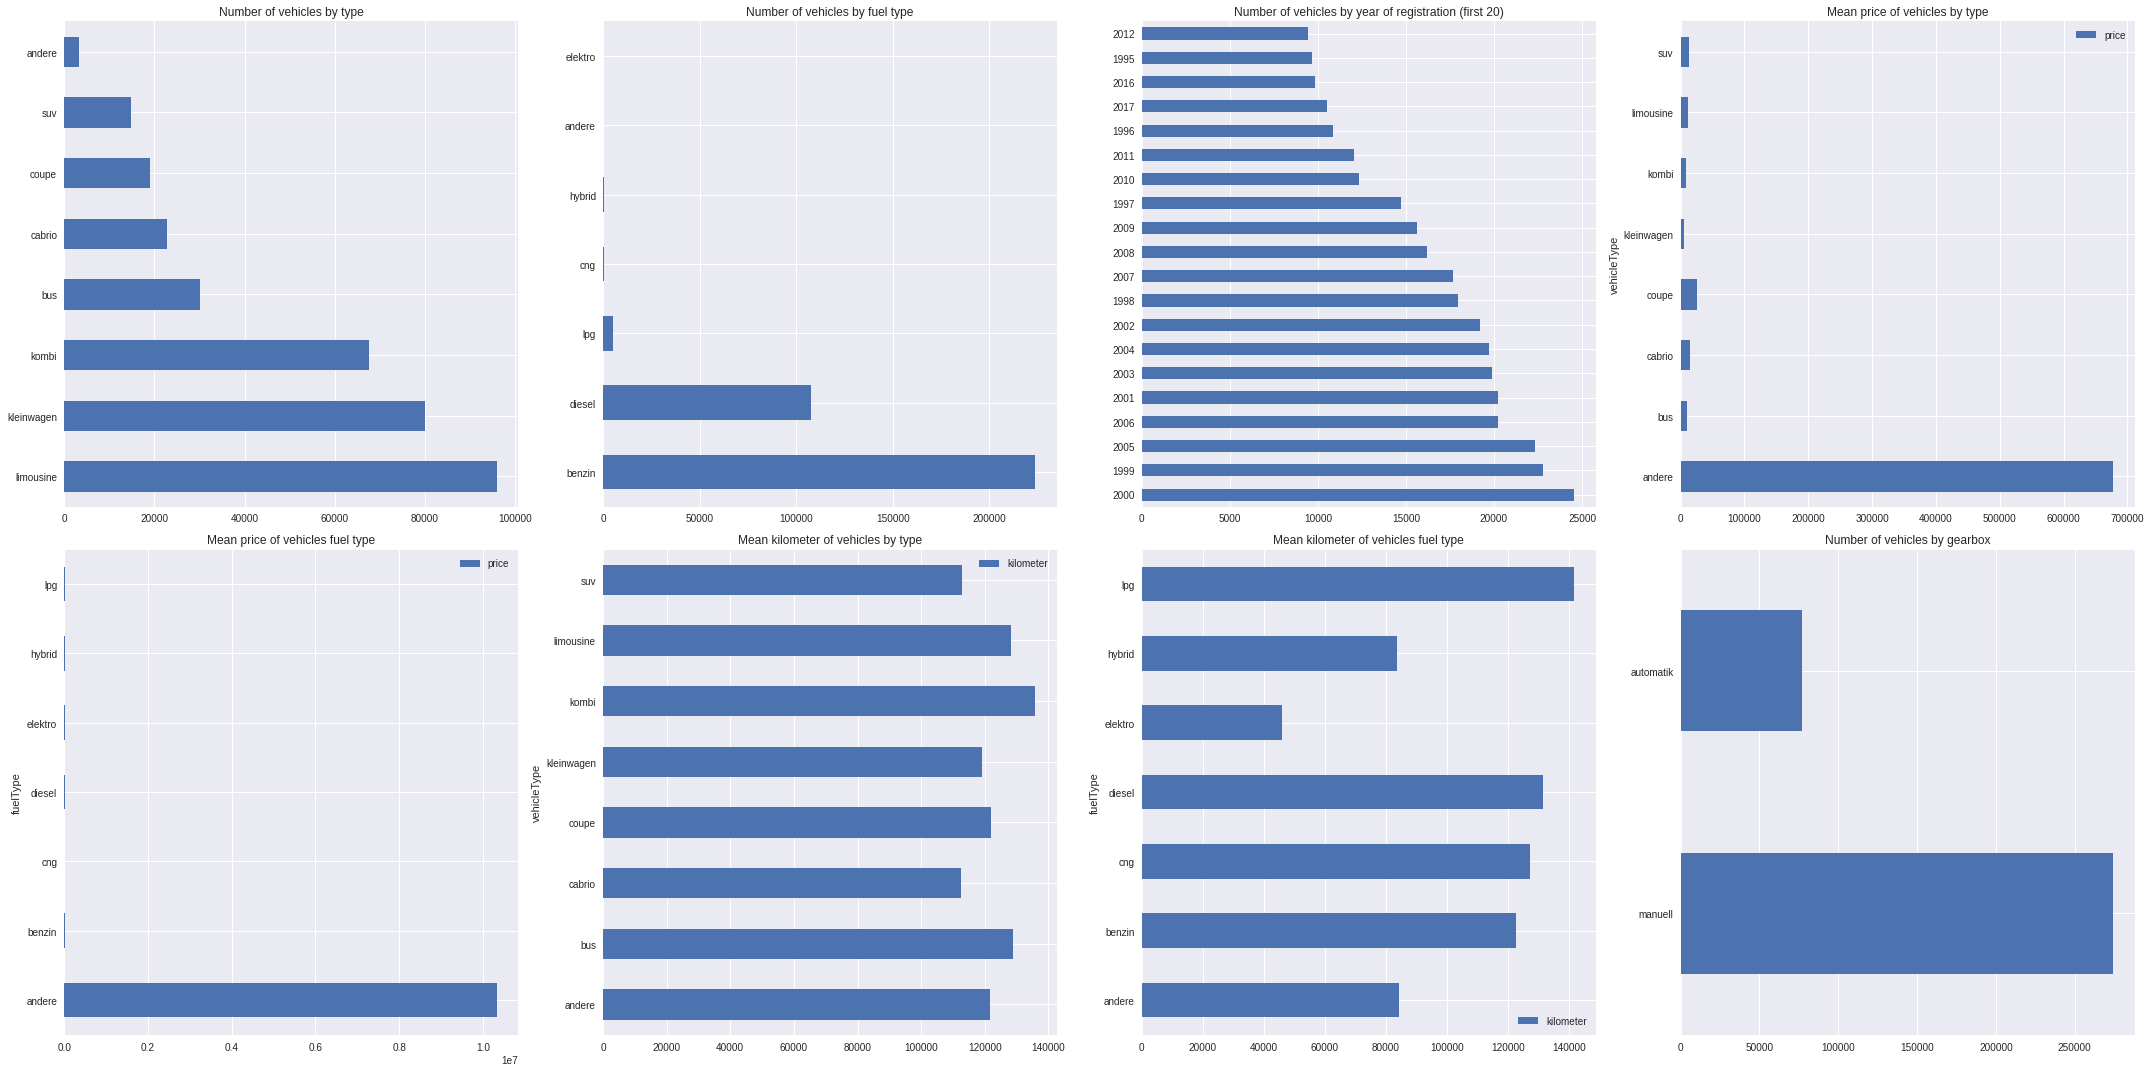

In [ ]:
fig,ax = plt.subplots(2,4,figsize=(30,15))
auto.vehicleType.value_counts().plot.barh(ax=ax.ravel()[0],title='Number of vehicles by type')
auto.fuelType.value_counts().plot.barh(ax=ax.ravel()[1],title='Number of vehicles by fuel type')
auto.yearOfRegistration.value_counts()[:20].plot.barh(ax=ax.ravel()[2],title='Number of vehicles by year of registration (first 20)')
auto.groupby('vehicleType')[['price']].mean().plot.barh(ax=ax.ravel()[3],title='Mean price of vehicles by type')
auto.groupby('fuelType')[['price']].mean().plot.barh(ax=ax.ravel()[4],title='Mean price of vehicles fuel type')
auto.groupby('vehicleType')[['kilometer']].mean().plot.barh(ax=ax.ravel()[5],title='Mean kilometer of vehicles by type')
auto.groupby('fuelType')[['kilometer']].mean().plot.barh(ax=ax.ravel()[6],title='Mean kilometer of vehicles fuel type')
auto.gearbox.value_counts().plot.barh(ax=ax.ravel()[7],title='Number of vehicles by gearbox')
plt.tight_layout()

## Kilometers and Prices by Brand and Model

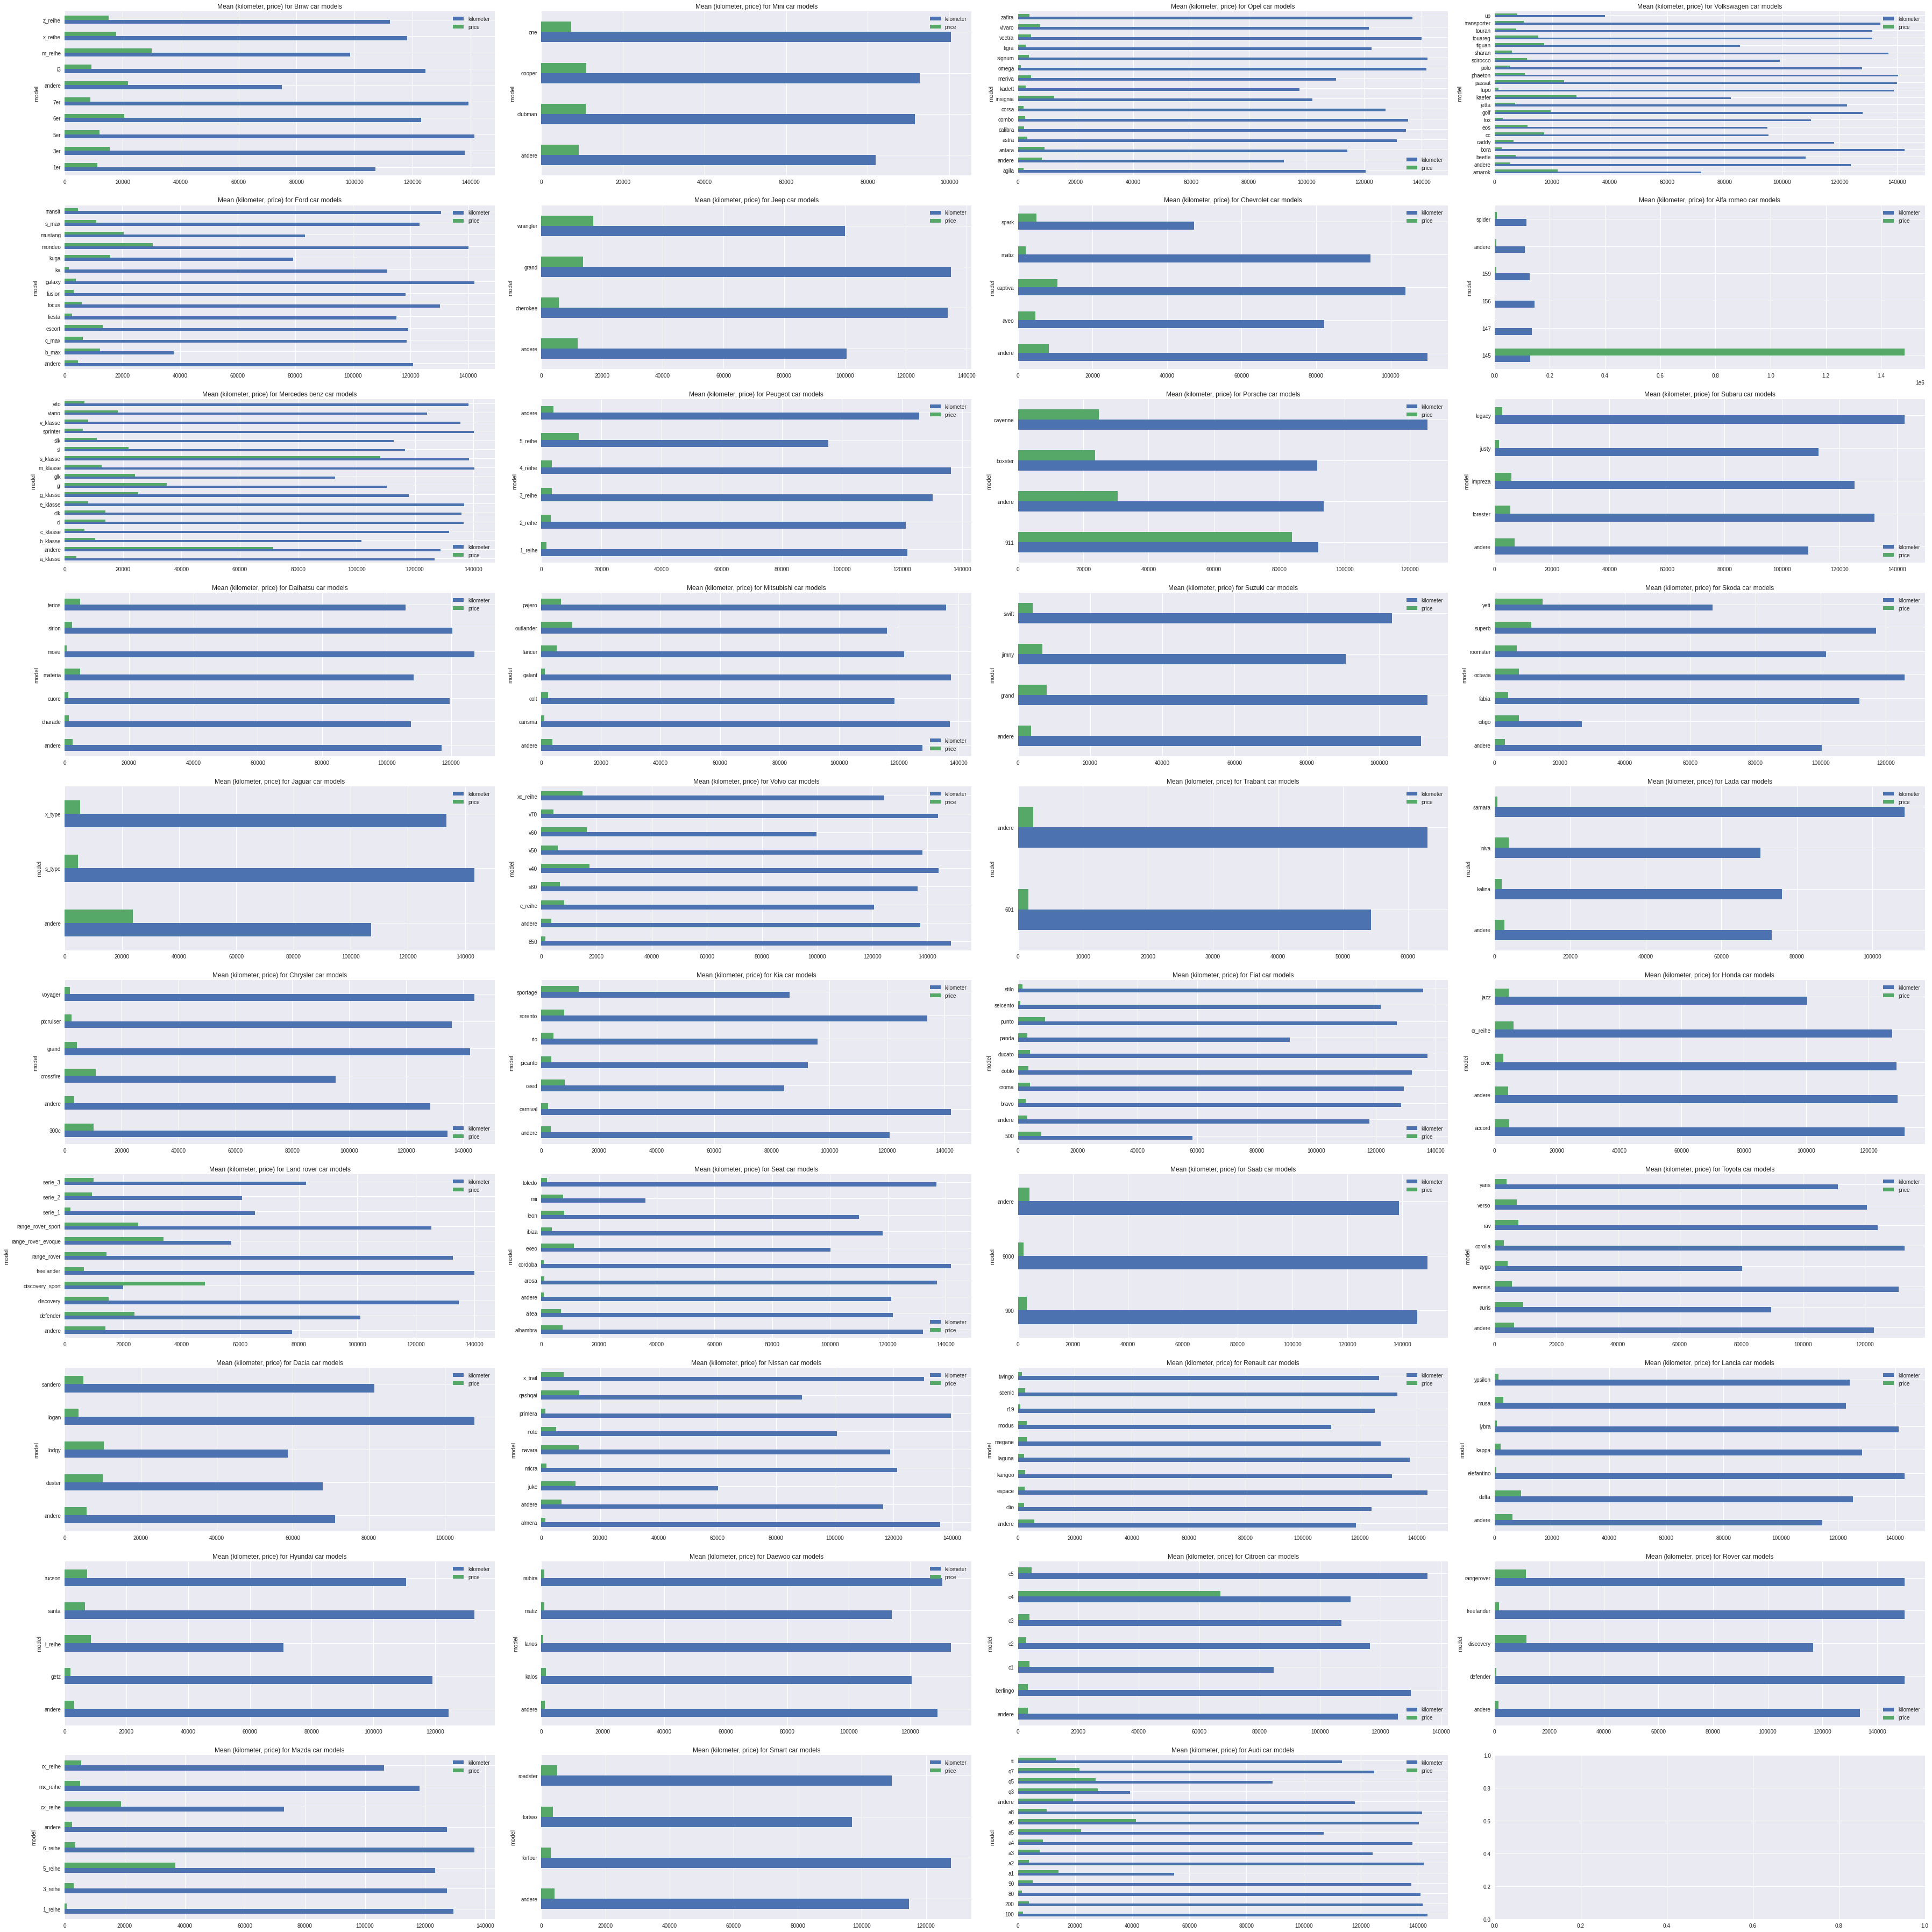

In [ ]:
tmp = auto.groupby(['brand','model']).agg({
    'kilometer': 'mean',
    'price': 'mean'
})
t = list(set([x[0] for x in tmp.index]))
fig, ax = plt.subplots(int(len(t) / 4)+1, 4,figsize=(50,50))

for i,brand in enumerate(t):
  try:
    tmp.loc[brand].plot.barh(ax=ax.ravel()[i], title=f'Mean (kilometer, price) for {brand.replace("_"," ").capitalize()} car models')
  except:
    print(f'error for {brand}')
    continue
plt.tight_layout()

## After the quick overview let's build a model to help us set the price

`XGBoost` and `LabelEncoder` should do the job for us

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from collections import defaultdict
d = defaultdict(LabelEncoder)
d

defaultdict(sklearn.preprocessing._label.LabelEncoder, {})

`x_cols` are our `features` and `target` is what we look for to `predict`

In [ ]:
x_cols=['brand','model','kilometer','yearOfRegistration','monthOfRegistration','fuelType','vehicleType','notRepairedDamage','powerPS','gearbox']
target = 'price'

* Copy the dataframe without the missing values
* Define the columns that need encoding
* Apply the encoding

In [ ]:
auto_copy = auto.dropna().copy()
enc_cols = list(set(x_cols) - set(['powerPS','yearOfRegistration','monthOfRegistration','kilometer']))
auto_copy[enc_cols] = auto_copy[enc_cols].apply(lambda x: d[x.name].fit_transform(x))

After we dropped the missing values we still have 70% of the data

In [ ]:
len(auto_copy) / len(auto)

0.7023858228720312

Now, let's split our data into `train`/`test`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(auto_copy[x_cols], auto_copy[target], test_size=0.33, random_state=42)

Further on we can use the `XGBRegressor` with a `gamma` distribution and train it on the `train` data

In [ ]:
%%time
xg = xgb.XGBRegressor(objective ='reg:gamma', n_estimators = 1000).fit(X_train,y_train)

CPU times: user 1min 23s, sys: 67.9 ms, total: 1min 23s
Wall time: 1min 23s


Make a `dataframe` with `test` target vs `predicted` test target

In [ ]:
preds = pd.DataFrame({
    'true': y_test,
    'predicted': xg.predict(X_test)
})

Use MAE for our metric

In [ ]:
metrics.mean_absolute_error(preds.true,preds.predicted)

2078.077884307823

Let's have a look into our `Feature Importance`

<Figure size 720x720 with 0 Axes>

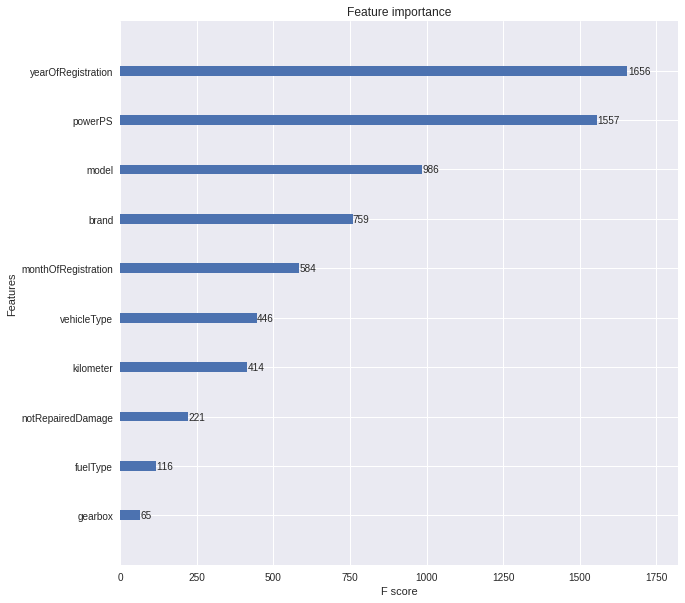

In [ ]:
plt.figure(figsize=sizes.small)
xgb.plot_importance(xg)
plt.show()

And here we have a copy of our `test` dataframe with `decoded` columns, but also with `original` and `predicted` price

In [ ]:
xt = X_test.copy()
xt['original_price'] = y_test
xt['predicted_price'] = xg.predict(X_test)
xt[enc_cols] = xt[enc_cols].apply(lambda x: d[x.name].inverse_transform(x))
xt[:30]

,brand,model,kilometer,yearOfRegistration,monthOfRegistration,fuelType,vehicleType,notRepairedDamage,powerPS,gearbox,original_price,predicted_price
336427,volkswagen,polo,150000,2003,12,benzin,kleinwagen,nein,75,manuell,2990,2454.927246
339513,ford,fiesta,125000,1998,6,benzin,kleinwagen,nein,0,automatik,850,980.325439
54995,renault,megane,150000,1999,11,benzin,kombi,nein,0,manuell,950,830.935181
297839,mercedes_benz,a_klasse,150000,2000,5,diesel,limousine,nein,90,automatik,1500,1719.381470
353328,volkswagen,andere,125000,1995,5,benzin,limousine,nein,90,automatik,1700,1200.977295
213296,bmw,3er,125000,1997,9,benzin,limousine,nein,102,manuell,2450,1498.408813
57967,opel,agila,30000,2009,11,benzin,kleinwagen,nein,60,manuell,5850,5020.946777
114503,nissan,micra,150000,2000,10,benzin,kleinwagen,nein,54,manuell,399,853.951660
126949,seat,ibiza,80000,2010,8,diesel,kleinwagen,nein,143,manuell,10760,10703.540039
22843,audi,a6,150000,2007,11,diesel,kombi,nein,179,manuell,10450,21701.361328
